# Deep Learning Assignment 2: American Sign Language (ASL) detection using CNN (Part 3)

* The custom CNN is trained using the optimal hyperparameters obtained in part 1 without an early stopping mechanism. 
* The best model instance with the highest f1-score and the best epoch is saved during training.

In [1]:
!rm -rf data/kaggle

In [2]:
# Import libraries.
from collections import defaultdict
import copy
import json
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import random
import shutil
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models

In [3]:
# Set seed.
seed = 42
np.random.seed(seed)

# Set seed for PyTorch.
torch.manual_seed(seed)

# Set seed for inbuilt random function.
random.seed(seed)

# Use Metal GPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Increase DPI for plots.
plt.rcParams['figure.dpi'] = 500

## Exploratory Data Analysis

In [4]:
# Download data
base_path = 'data/kaggle/'
data_path = base_path + 'asl_dataset'
if not os.path.exists(data_path):
    path = kagglehub.dataset_download("ayuraj/asl-dataset")
    shutil.copytree(path, base_path, dirs_exist_ok=True)
    if os.path.exists(data_path+'/asl_dataset'):
        shutil.rmtree(data_path+'/asl_dataset') # Extra folder

In [5]:
# Find class distribution
class_distribution = defaultdict(int)
for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    if os.path.isdir(class_folder):
        # Count number of images in this class folder
        num_images = len([img for img in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, img))])
        class_distribution[class_name] = num_images
distribution = pd.DataFrame(list(map(list, class_distribution.items())), columns=['class', 'count'])
distribution

,class,count
0,r,70
1,u,70
2,9,70
3,0,70
4,7,70
5,i,70
6,n,70
7,g,70
8,6,70
9,z,70


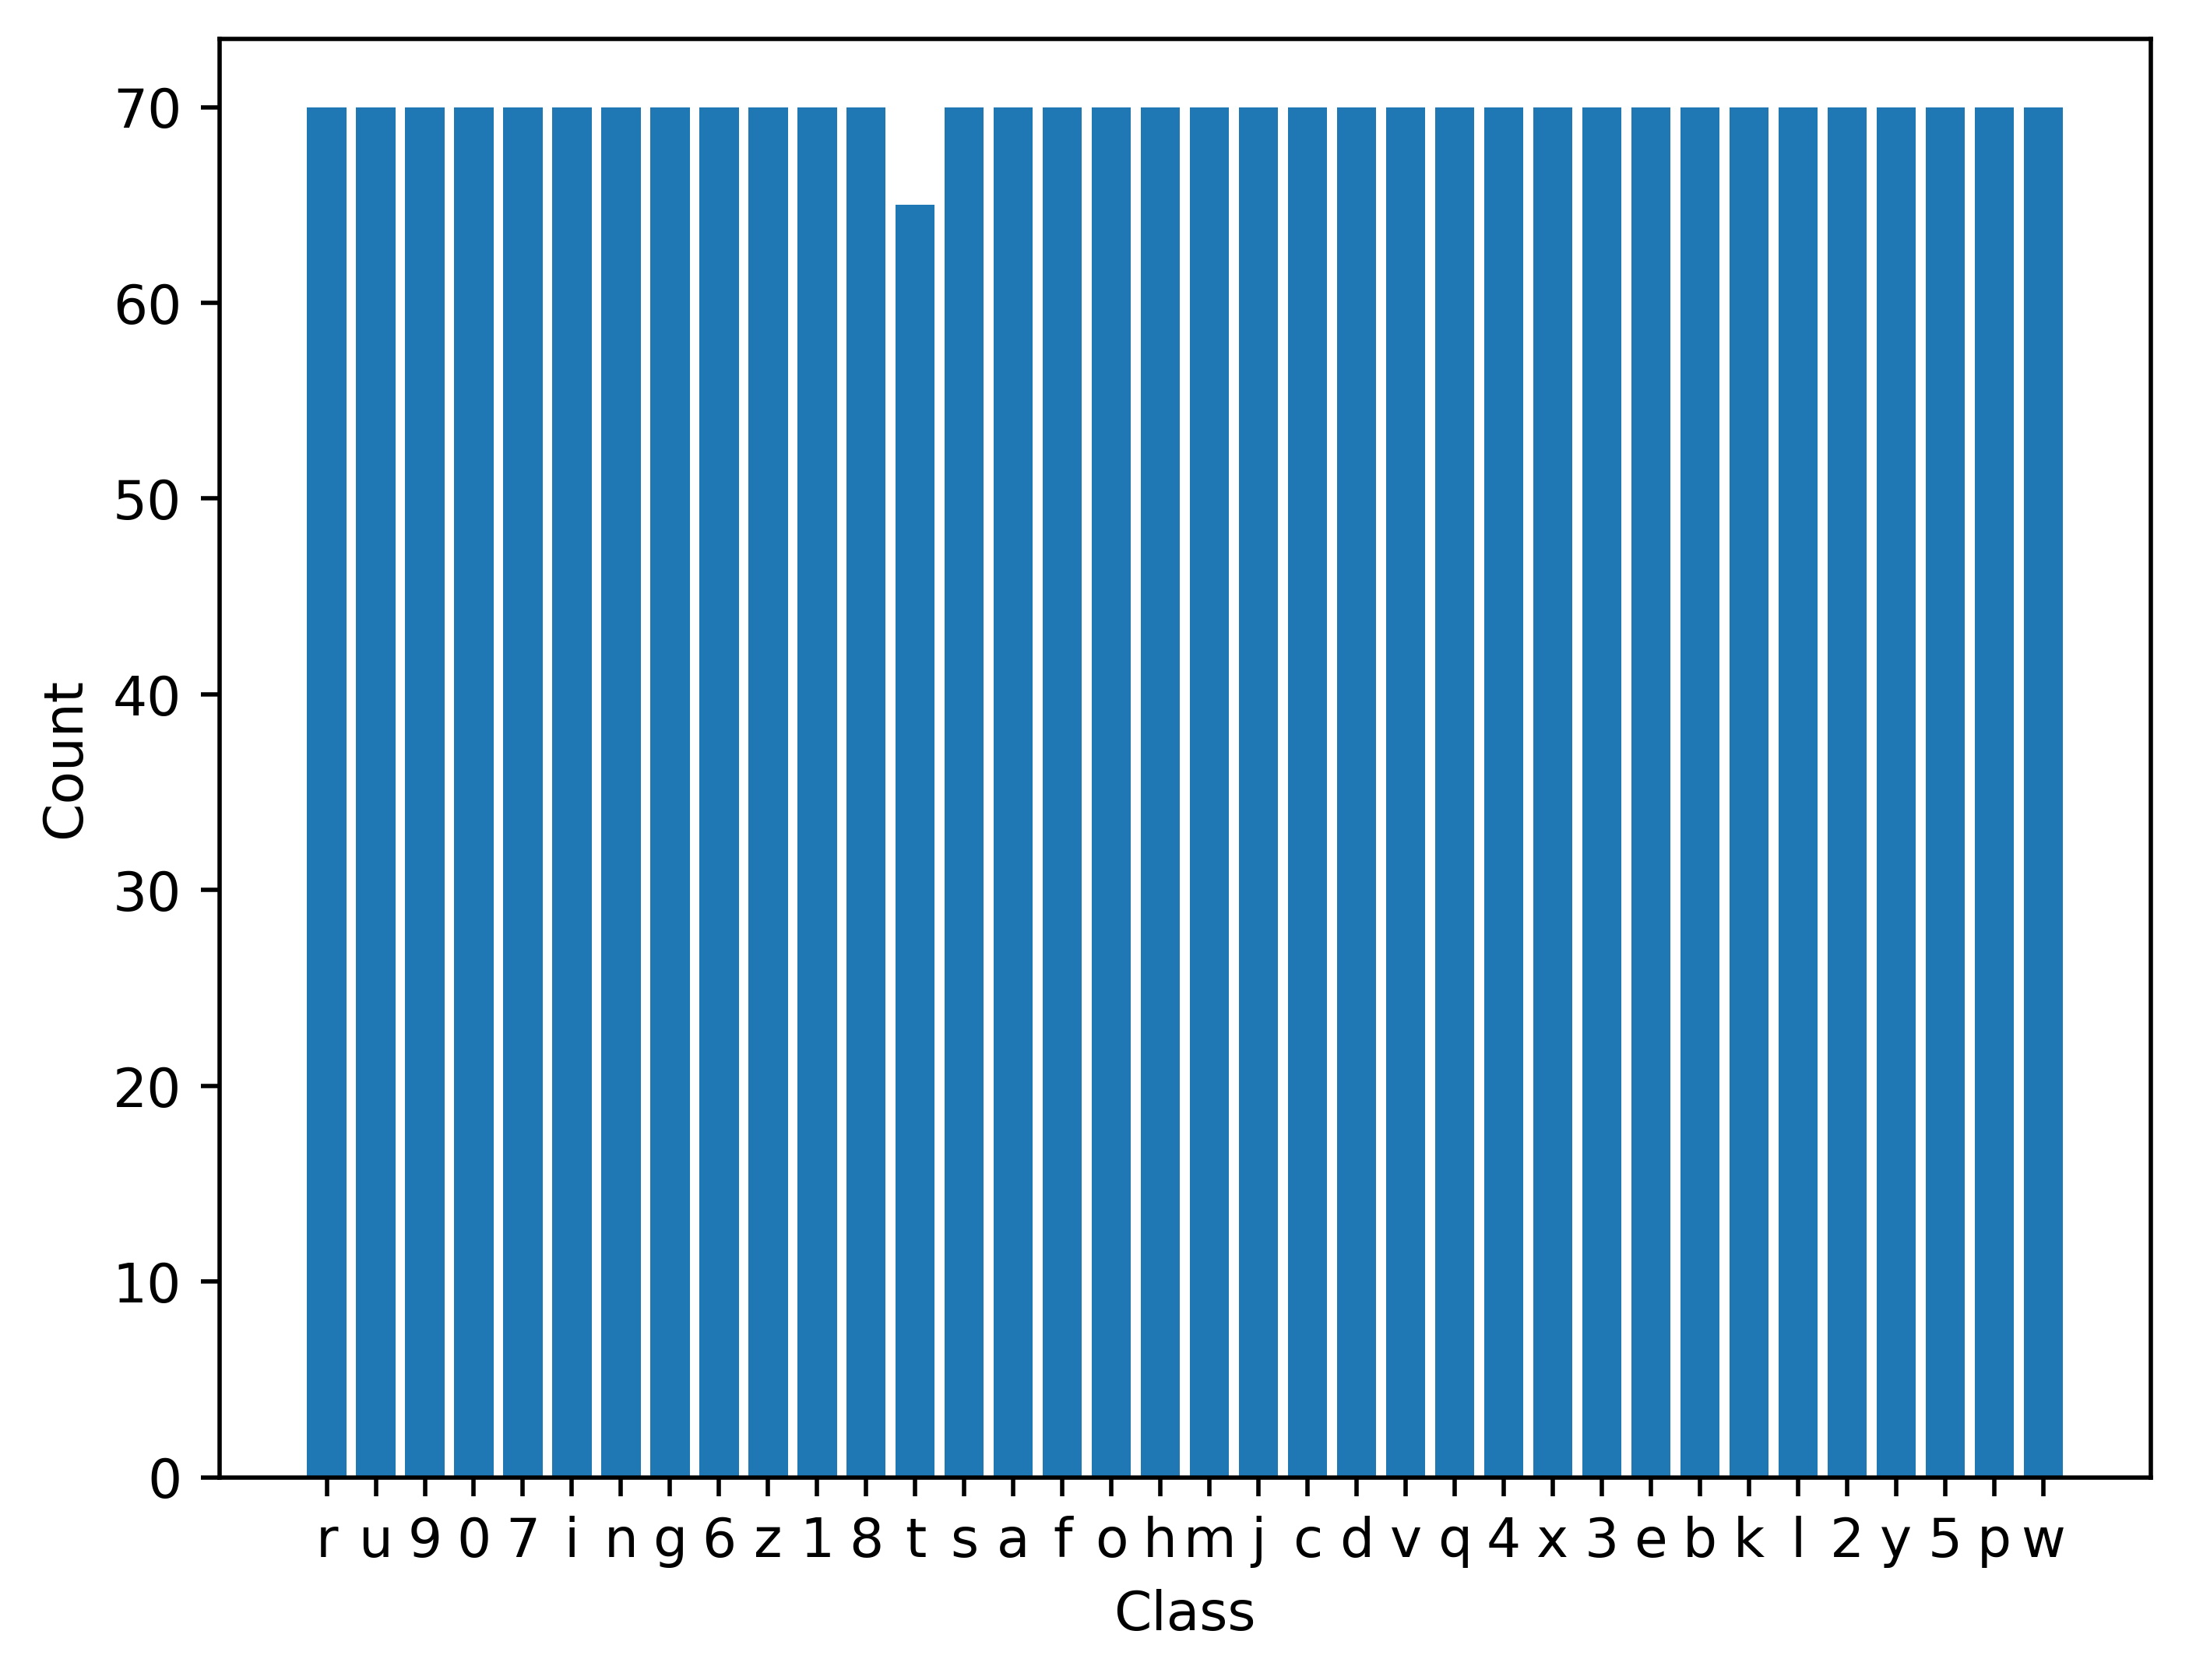

In [6]:
plt.bar(distribution['class'], distribution['count'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [7]:
distribution['count'].max()

70

In [8]:
distribution.iloc[distribution['count'].argmin()]

class     t
count    65
Name: 12, dtype: object

## Data Pre-processing

In [9]:
# Oversampling the minor class.
for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    if os.path.isdir(class_folder):
        # Count number of images in this class folder
        images = [class_folder + '/' + img for img in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, img))]
        num_images = len(images)
        diff = distribution['count'].max() - num_images
        i = 0
        while diff > 0:
            # Copy until balanced.
            sp = images[i].split('.')
            sp[0] += '_clone'
            shutil.copy(images[i], '.'.join(sp))
            diff -= 1
            i += 1
            

In [10]:
# Split into test and training set.
test_data_count_per_class = int(0.2 * distribution['count'].max())
train_data_path = base_path + 'asl_dataset_split/train'
test_data_path = base_path + 'asl_dataset_split/test'

# Create list of images per class and shuffle them.
images = {}
for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    images[class_name] = [img for img in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, img))]
    random.shuffle(images[class_name])
                    
# Copy files into train and test folders.                
for class_name, img in images.items():
    os.makedirs(f"{train_data_path}/{class_name}", exist_ok=True)
    os.makedirs(f"{test_data_path}/{class_name}", exist_ok=True)
    for train_img in img[test_data_count_per_class:]:
        shutil.copy(f"{data_path}/{class_name}/{train_img}", f"{train_data_path}/{class_name}/{train_img}")
        
    for test_img in img[:test_data_count_per_class]:
        shutil.copy(f"{data_path}/{class_name}/{test_img}", f"{test_data_path}/{class_name}/{test_img}")

In [11]:
# Define transforms
num_classes = distribution.shape[0]
model_init = {"pretrained": True, "num_classes": num_classes}
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalisation used in ImageNet
])

# Load the dataset
dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

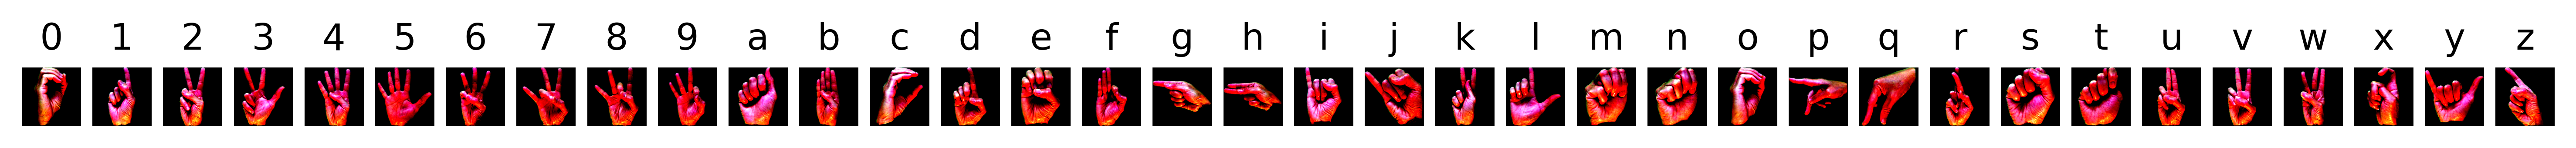

In [12]:
# Show a sample image from each class.
samples = {}
class_names = dataset.classes
for img, label in dataset:
    if label not in samples:
        samples[label] = img 
    if len(samples) == len(class_names):
        break

plt.figure(figsize=(15, 3))
for i, (label, img) in enumerate(samples.items()):
    img = img.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C) for displaying
    plt.subplot(1, len(class_names), i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.show()

## Modeling

In [13]:
# Define models
class CustomNet(nn.Module):
    """
    Modify the final layer to make the pre-trained model compatible with the dataset.
    """
    def __init__(self, core_net, num_classes=10, pretrained=True):
        super().__init__()
        self.num_classes = num_classes
        
        self.model = core_net(pretrained=pretrained)
        
        # Freeze all layers.
        if pretrained and not isinstance(self.model, CustomCNN):
            for param in self.model.parameters():
                param.requires_grad = False
        
        # Replace the classifier head with a new one for the specific number of classes
        if hasattr(self.model,'classifier'):
            in_features = self.model.classifier[-1].in_features
            self.model.classifier[-1] = nn.Linear(in_features, num_classes)
        
            # Make classifier trainable.
            for param in self.model.classifier.parameters():
                param.requires_grad = True
        else:
            in_features = self.model.fc.in_features
            self.model.fc = nn.Linear(in_features, num_classes)
        
            # Make classifier trainable.
            for param in self.model.fc.parameters():
                param.requires_grad = True
    
    def forward(self, X):
        return F.log_softmax(self.model(X), dim=1)

class CustomCNN(nn.Module):
    """Customized progressive CNN"""
    def __init__(self, pretrained=None, num_classes=36):
        super(CustomCNN, self).__init__()
        self.convs = nn.ModuleList()
        self.batchNorms = nn.ModuleList()
        self.classifier = nn.ModuleList()
        self.batchNorms_classifier = nn.ModuleList()
        current_size = 224
        in_channels = 3
        out_channels = 2 * in_channels
        while current_size > 1:
            kernel_size = current_size // 2 + 1
            out_channels = 2 * in_channels
            self.convs.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1))
            self.batchNorms.append(nn.BatchNorm2d(out_channels))
            in_channels = out_channels
            current_size = current_size - kernel_size + 1
        
        hsize = out_channels * current_size * current_size
        out_size = hsize // 2
        while hsize > 2 * num_classes:
            out_size = hsize // 2
            self.classifier.append(nn.Linear(hsize, out_size))
            self.batchNorms_classifier.append(nn.BatchNorm1d(out_size))
            hsize = out_size

        self.classifier.append(nn.Linear(out_size, num_classes))
        
    def forward(self, x):
        for i in range(len(self.convs)):
            if i == len(self.convs) - 1:
                x = self.batchNorms[i](self.convs[i](x))
            else:
                x = F.leaky_relu(self.batchNorms[i](self.convs[i](x)))
        x = torch.flatten(x, 1)
        for i, layer in enumerate(self.classifier):
            if i == len(self.classifier) - 1:
                x = layer(x)
            else:
                x = F.leaky_relu(self.batchNorms_classifier[i](layer(x)))
        return x

# Models to be tested.
models_dict = {
    "CustomCNN": CustomCNN,
    # "ResNet18": models.resnet18,
    # "AlexNet": models.alexnet
}

In [14]:
# Hyperparameters for grid search
k_folds = 3
max_epochs = 250
param_grid = {
    'learning_rate': [0.01],
    'batch_size': [64],
    'optimizer': ['SGD',]
}

In [15]:
# K-Fold Cross Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

In [16]:
def square_matrix(matrix):
    """
    Convert sparse matrix to dense matrix.
    """
    max_length = max(len(row) for row in matrix)
    
    # Pad each row by duplicating the last element until it matches max_length
    for row in matrix:
        row.extend([row[-1]] * (max_length - len(row)))
    
    return matrix

In [17]:
# Train and evaluate the model
def train_evaluate_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=max_epochs):
    train_losses, val_losses = [], []
    prev_eff_loss = np.inf
    mx_f1 = 0
    mx_val_acc = 0
    mx_recall = 0
    mx_precision = 0
    best_model = copy.deepcopy(model)
    best_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss_avg = running_loss / len(train_loader)
        train_losses.append(train_loss_avg)

        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
        val_loss_avg = val_loss / len(val_loader)
        val_losses.append(val_loss_avg)
        val_accuracy = accuracy_score(val_labels, val_preds)
        precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
        recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
        f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
        print(f"[{epoch+1}/{num_epochs}] loss:{train_loss_avg: .3f} val loss: {val_loss_avg: .3f} val accuracy: {val_accuracy: .3f} f1-score: {f1: .3f}")

        if f1 > mx_f1:
            # Save the best model.
            best_model = copy.deepcopy(model)
            mx_f1 = f1
            mx_val_acc = val_accuracy
            mx_precision = precision
            mx_recall = recall
            best_epochs = epoch

        # Early stopping mechanism.
        # eff_loss = (abs(val_loss_avg) + abs(train_loss_avg)) + abs(val_loss_avg - train_loss_avg)

        # if epoch >= 5 and eff_loss > prev_eff_loss:
        #     break

        # prev_eff_loss = eff_loss
    return train_losses, val_losses, mx_val_acc, mx_precision, mx_recall, mx_f1, best_model, best_epochs

In [18]:
# Run grid search with cross-validation
results = {model_name: [] for model_name in models_dict.keys()}

for model_name, model in models_dict.items():
    print(f"Grid search on {model_name}")
    print(CustomNet(model, **model_init))
    for params in ParameterGrid(param_grid):
        print(f"Parameters: {params}")
        accuracies, precisions, recalls, f1_scores = [], [], [], []
        all_train_losses, all_val_losses = [], []
        all_model_weights = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            print(f"Fold #{fold+1}")
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)
            train_loader = DataLoader(train_subset, batch_size=params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params['batch_size'], shuffle=False)
            
            model_copy = nn.DataParallel(CustomNet(model, **model_init)).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = getattr(optim, params['optimizer'])(model_copy.parameters(), lr=params['learning_rate'])

            train_loss, val_loss, acc, prec, rec, f1, model_final, best_epochs = train_evaluate_model(model_copy, train_loader, val_loader, criterion, optimizer, device)
            accuracies.append(acc)
            precisions.append(prec)
            recalls.append(rec)
            f1_scores.append(f1)
            all_train_losses.append(train_loss)
            all_val_losses.append(val_loss)
            all_model_weights.append(model_final)

        # Average metrics for this configuration
        avg_acc = np.mean(accuracies)
        avg_prec = np.mean(precisions)
        avg_rec = np.mean(recalls)
        avg_f1 = np.mean(f1_scores)

        # Best model weight across all folds.
        best_index = np.argmax(f1_scores)
        
        results[model_name].append({
            'params': params,
            'accuracy': avg_acc,
            'precision': avg_prec,
            'recall': avg_rec,
            'f1_score': avg_f1,
            'train_losses': np.mean(square_matrix(all_train_losses), axis=0),
            'val_losses': np.mean(square_matrix(all_val_losses), axis=0),
            'model': all_model_weights[best_index],
            'epochs': best_epochs
        })
        with open("results-custom-overfit.pkl", "wb") as file:
            pickle.dump(results, file)
        print(f"Accuracy: {avg_acc*100: .2f}%, f1-score: {avg_f1: .3f}, parameters: {params.items()}\n")


Grid search on CustomCNN
CustomNet(
  (model): CustomCNN(
    (convs): ModuleList(
      (0): Conv2d(3, 6, kernel_size=(113, 113), stride=(1, 1))
      (1): Conv2d(6, 12, kernel_size=(57, 57), stride=(1, 1))
      (2): Conv2d(12, 24, kernel_size=(29, 29), stride=(1, 1))
      (3): Conv2d(24, 48, kernel_size=(15, 15), stride=(1, 1))
      (4): Conv2d(48, 96, kernel_size=(8, 8), stride=(1, 1))
      (5): Conv2d(96, 192, kernel_size=(4, 4), stride=(1, 1))
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1))
      (7): Conv2d(384, 768, kernel_size=(2, 2), stride=(1, 1))
    )
    (batchNorms): ModuleList(
      (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): BatchNo

In [19]:
# Test set evaluation with the best model configurations
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

final_results = {}
losses_dict = {}
for model_name, model_results in results.items():
    best_config = max(model_results, key=lambda x: x['f1_score'])
    model = best_config['model'].to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, best_config['params']['optimizer'])(model.parameters(), lr=best_config['params']['learning_rate'])

    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds, average='macro')
    test_recall = recall_score(test_labels, test_preds, average='macro')
    test_f1 = f1_score(test_labels, test_preds, average='macro')
    
    final_results[model_name] = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'best_params': best_config['params']
    }
    losses_dict[model_name] = {
        'train_losses': best_config['train_losses'],
        'val_losses': best_config['val_losses']
    }


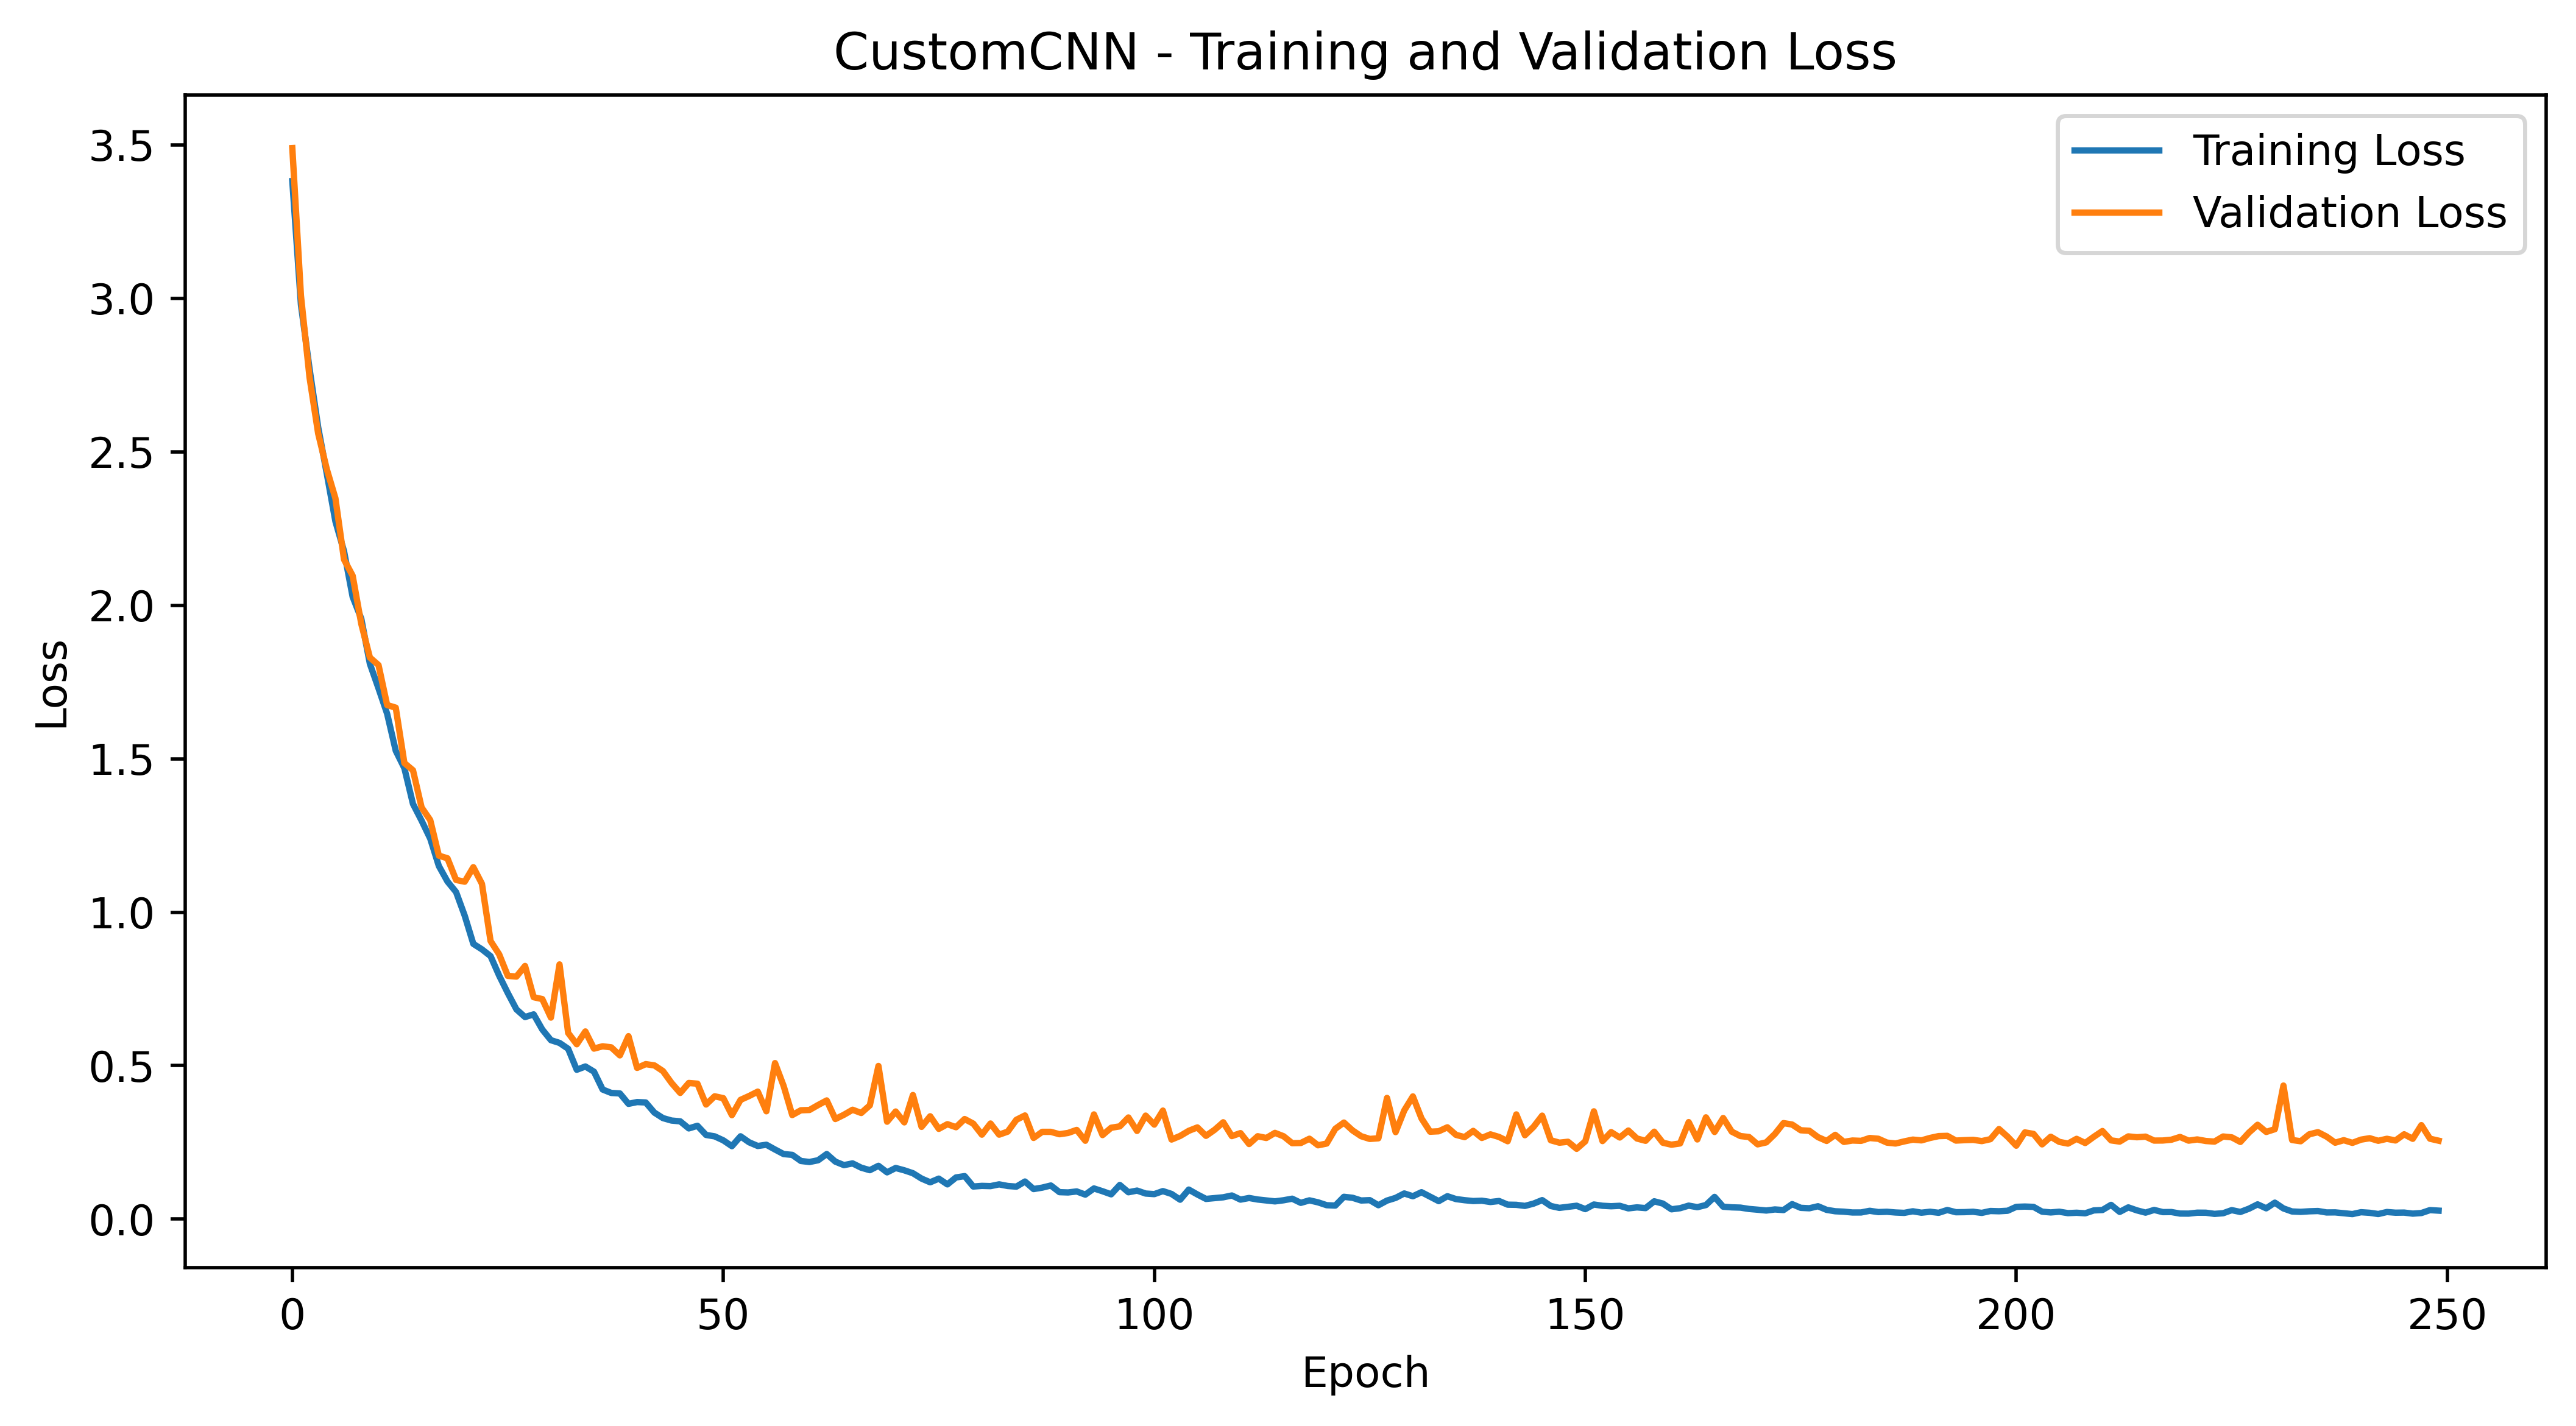

In [20]:
# Plot training and validation loss for each model
for model_name, losses in losses_dict.items():
    plt.figure(figsize=(10, 5))
    plt.plot(losses['train_losses'], label='Training Loss')
    plt.plot(losses['val_losses'], label='Validation Loss')
    plt.title(f"{model_name} - Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [21]:
# Print final comparison results
for model_name, metrics in final_results.items():
    print(f"{model_name} - Best Params: {metrics['best_params']}")
    print(f"Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1_score']:.4f}\n")


CustomCNN - Best Params: {'batch_size': 64, 'learning_rate': 0.01, 'optimizer': 'SGD'}
Accuracy: 0.9643, Precision: 0.9661, Recall: 0.9643, F1 Score: 0.9641



In [22]:
with open("results-custom-overfit.pkl", "wb") as file:
    pickle.dump(results, file)
with open("final_results-custom-overfit.json", "w") as file:
    json.dump(final_results, file, indent=4)

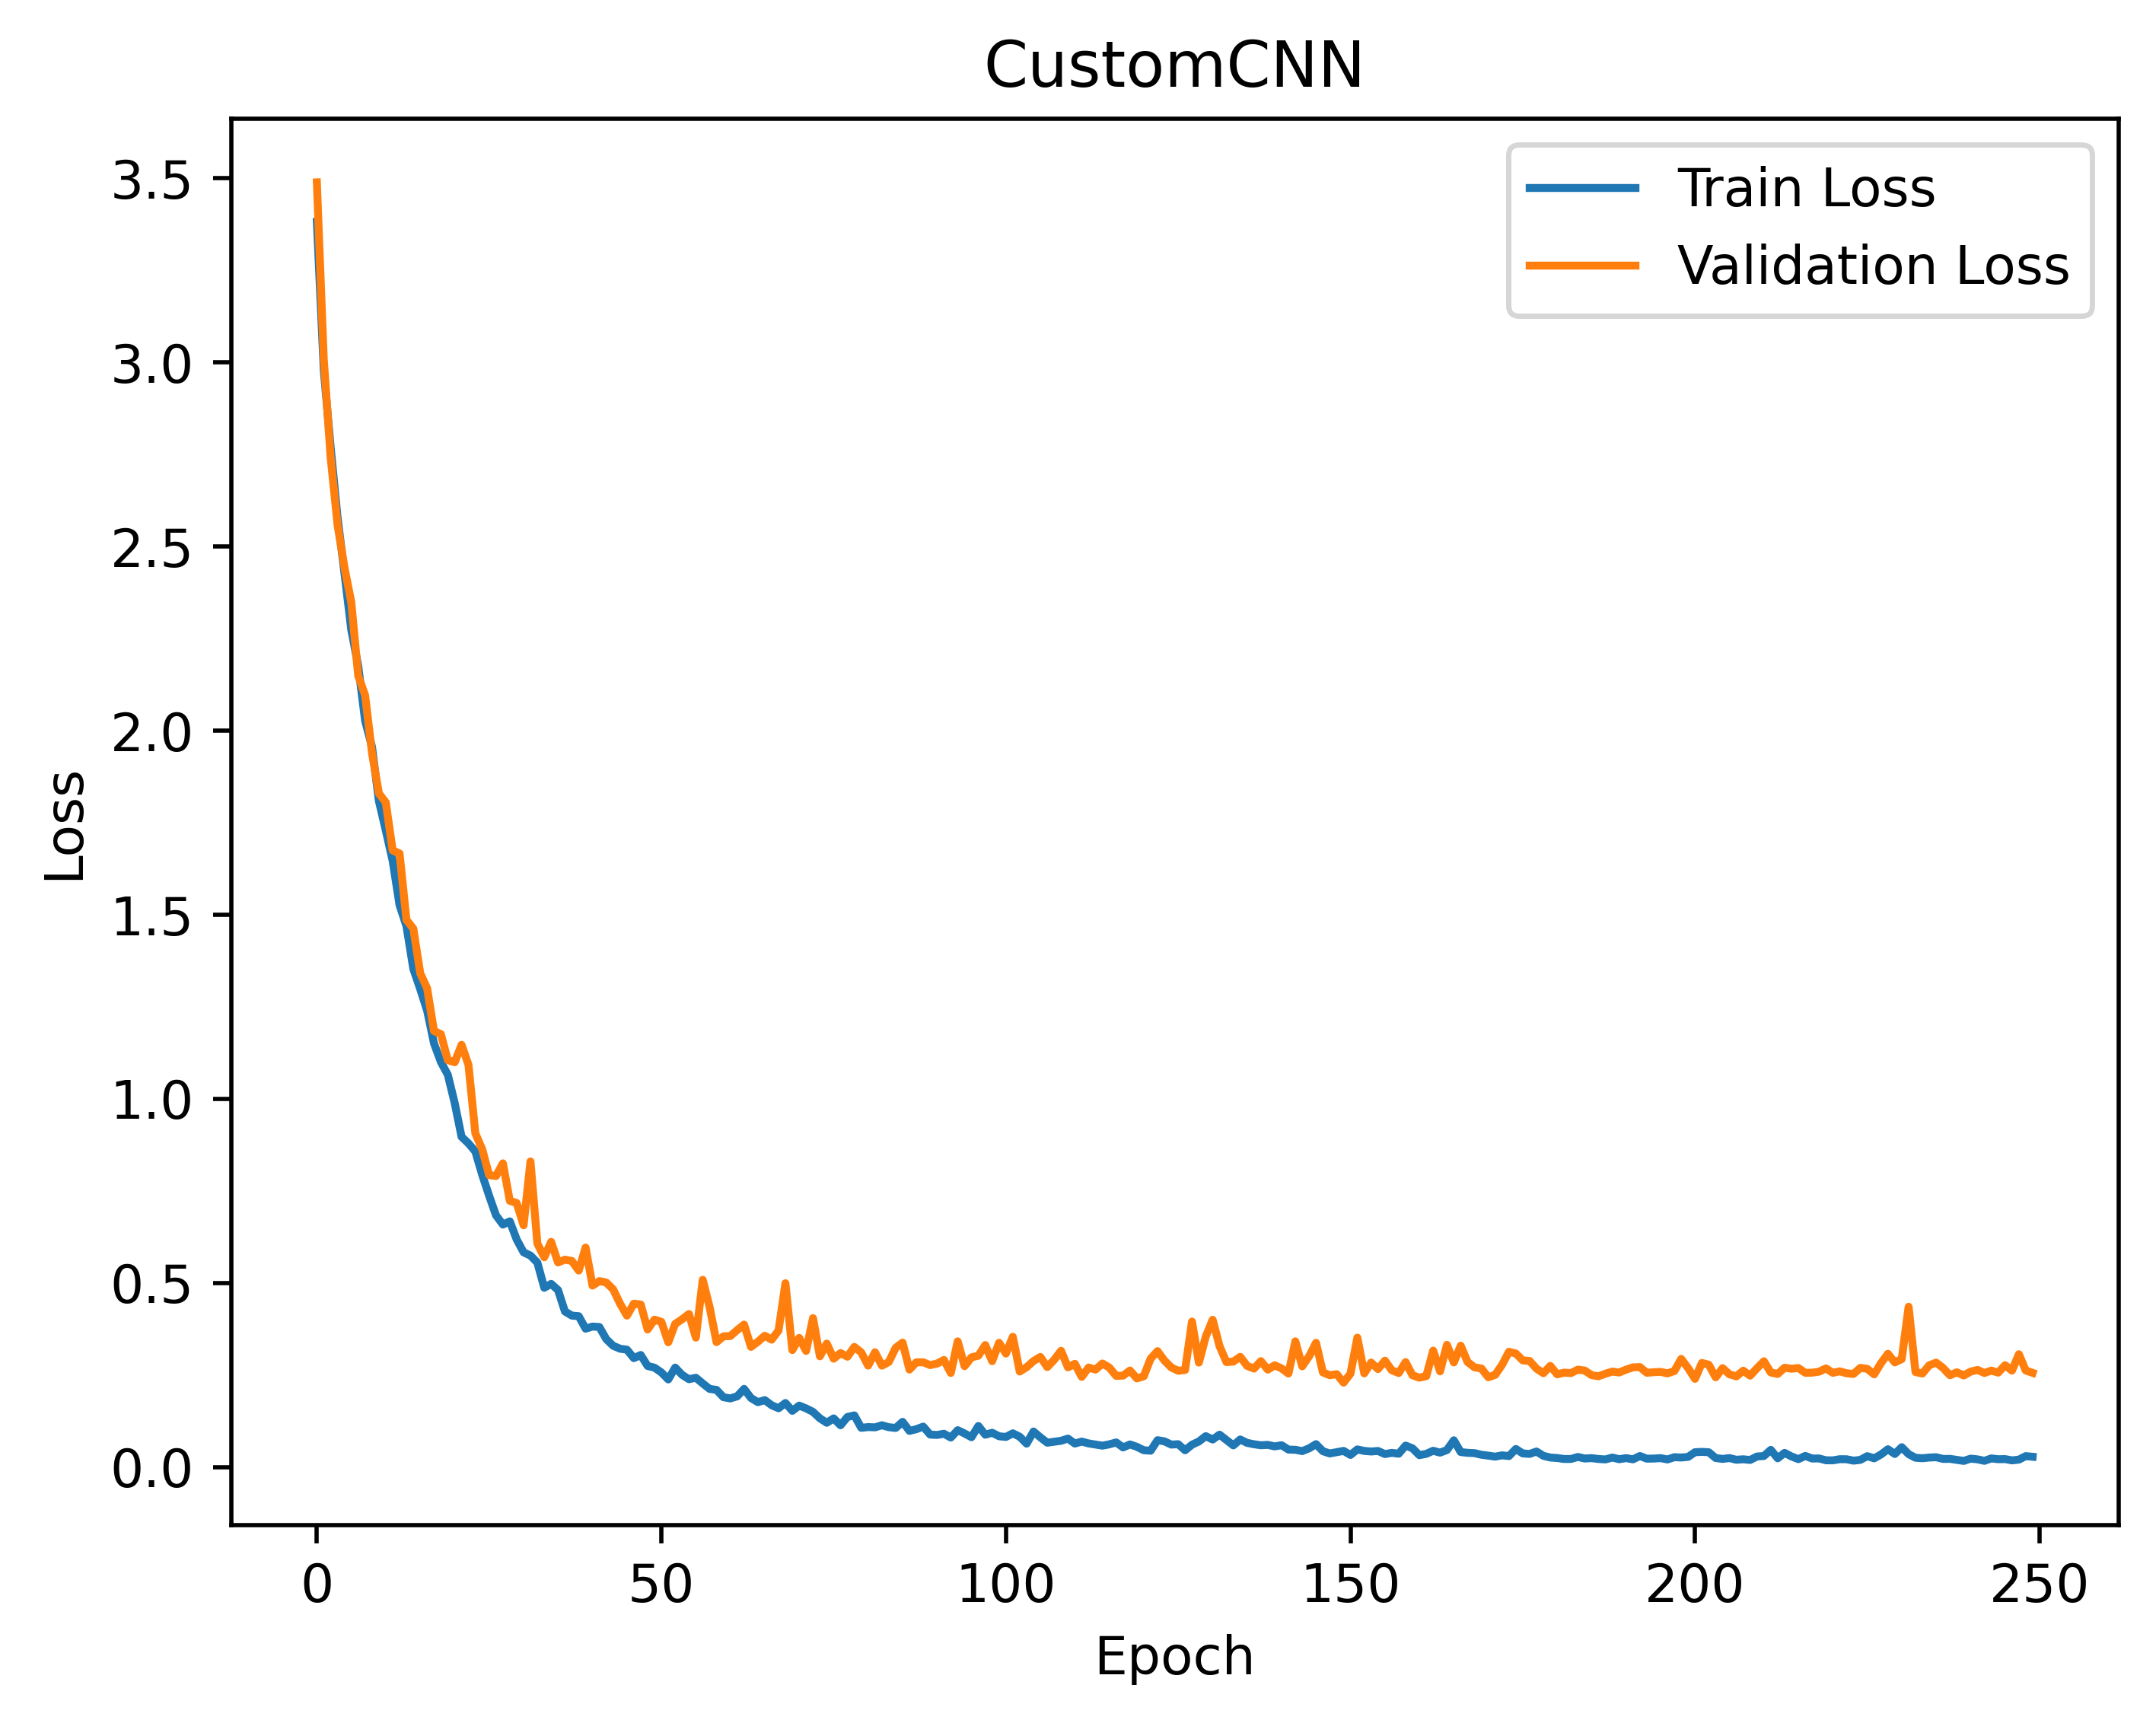

,Model,Accuracy,f1,Precision,Recall,Epoch,LR,Optimizer,Batch size,Parameters
0,CustomCNN,0.964286,0.964112,0.966089,0.964286,154,0.01,SGD,64,3798396


In [23]:
disp_res = []

for model, res in results.items():
  if len(res) > 0:
    best_config = max(list(res), key=lambda x: x['f1_score'])
    disp_res.append({
        'Model': model, 
        'Accuracy': final_results[model]['accuracy'], 
        'f1': final_results[model]['f1_score'],
        'Precision': final_results[model]['precision'],
        'Recall': final_results[model]['recall'],
        'Epoch': best_config['epochs'],
        'LR': best_config['params']['learning_rate'],
        'Optimizer': best_config['params']['optimizer'],
        'Batch size': best_config['params']['batch_size'],
        'Parameters': sum(p.numel() for p in best_config['model'].parameters())
    })
    train_loss = best_config['train_losses']
    val_loss = best_config['val_losses']
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(model)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

df = pd.DataFrame(disp_res, columns = list(disp_res[0].keys()))
df

In [24]:
from IPython.display import FileLink, display
display(FileLink(f'results-custom-overfit.pkl'))
display(FileLink(f'final_results-custom-overfit.json'))

/Users/abinshoby/Assignment/Deep Learning/Latest/results-custom-overfit.pkl

/Users/abinshoby/Assignment/Deep Learning/Latest/final_results-custom-overfit.json